# Soil Fertility Analysis using Random Forest Models

This notebook implements both Random Forest Classifier and Regressor models for soil fertility analysis using various soil parameters such as N, P, K, EC, and Fe content.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Exploration

Let's load our dataset and perform some initial exploratory data analysis.

In [2]:
# Load the dataset
df = pd.read_csv('../Datasets/dataset_1.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB
None

First few rows:
     N    P    K    EC    Fe  Output
0  138  8.6  560  0.62  0.31       0
1  213  7.5  338  0.75  0.86       0
2  163  9.6  718  0.51  0.86       0
3  157  6.8  475  0.58  0.54       0
4  270  9.9  444  0.40  0.76       1

Summary statistics:
               N           P           K          EC          Fe      Output
count  880.00000  880.000000  880.000000  880.000000  880.000000  880.000000
mean   246.73750   14.562159  499.978409    0.543659    4.140523    0.588636
std     77.38886   21.967755  124.22283

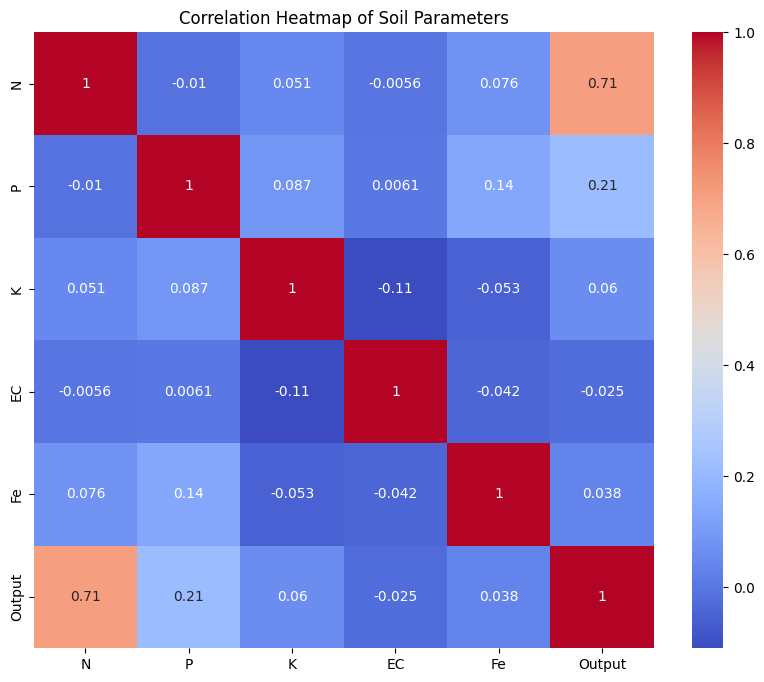

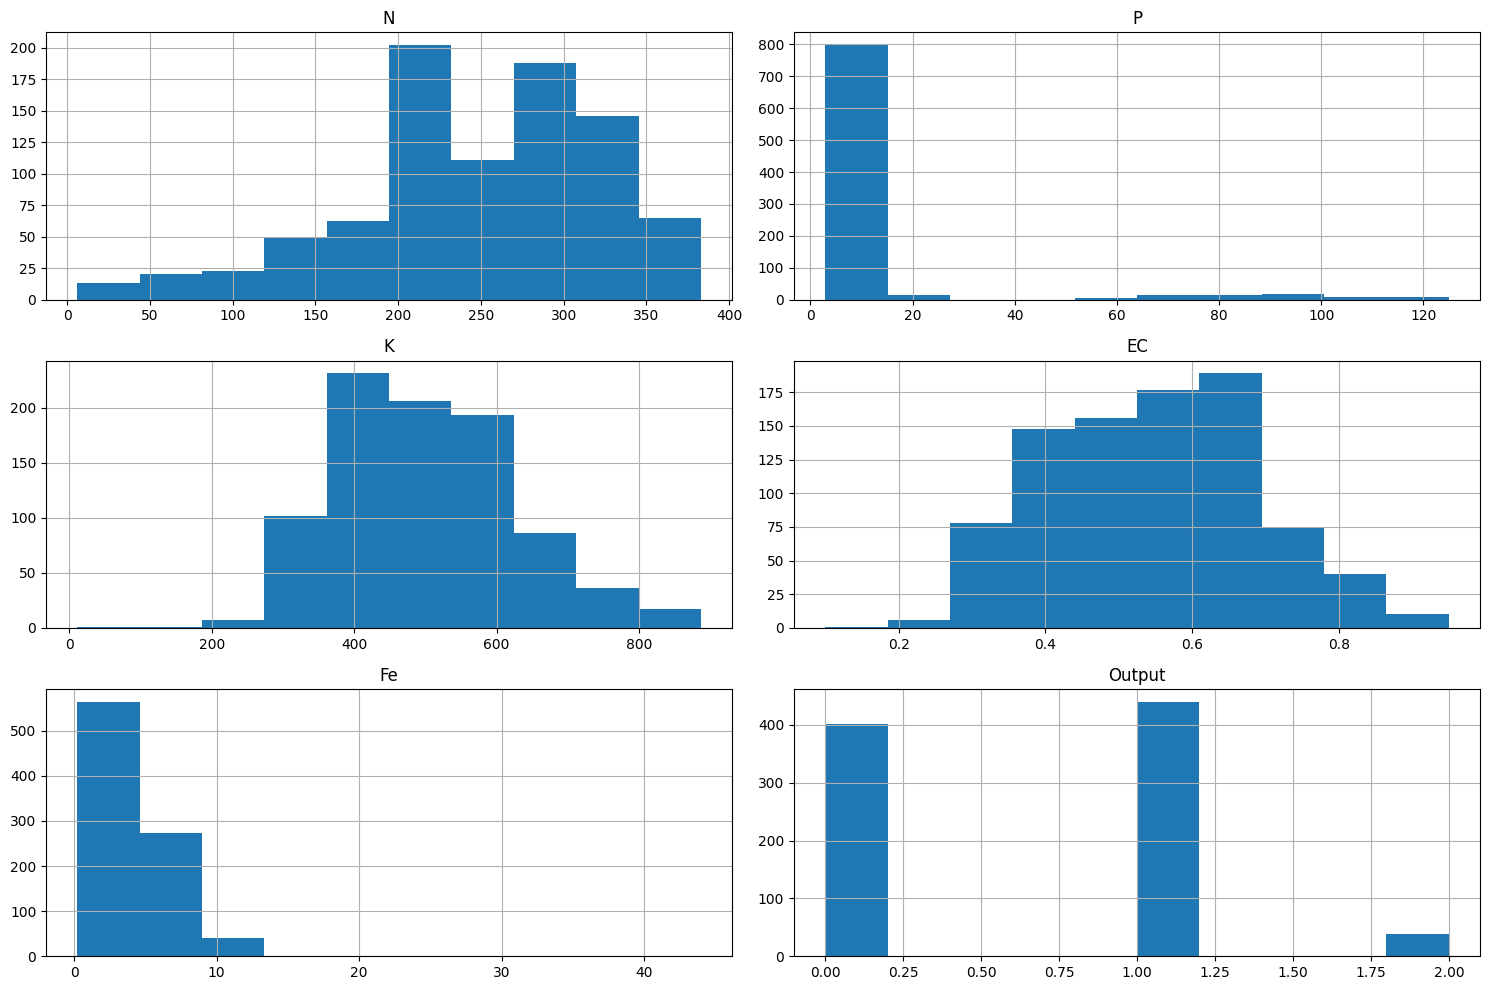

In [3]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Soil Parameters')
plt.show()

# Distribution of features
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In [4]:
# Separate features and target
X = df.drop('Output', axis=1)
y = df['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest Classifier

First, let's train and evaluate a Random Forest Classifier for predicting soil fertility class.

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        78
           1       0.89      0.88      0.88        88
           2       1.00      0.40      0.57        10

    accuracy                           0.88       176
   macro avg       0.92      0.74      0.79       176
weighted avg       0.89      0.88      0.87       176



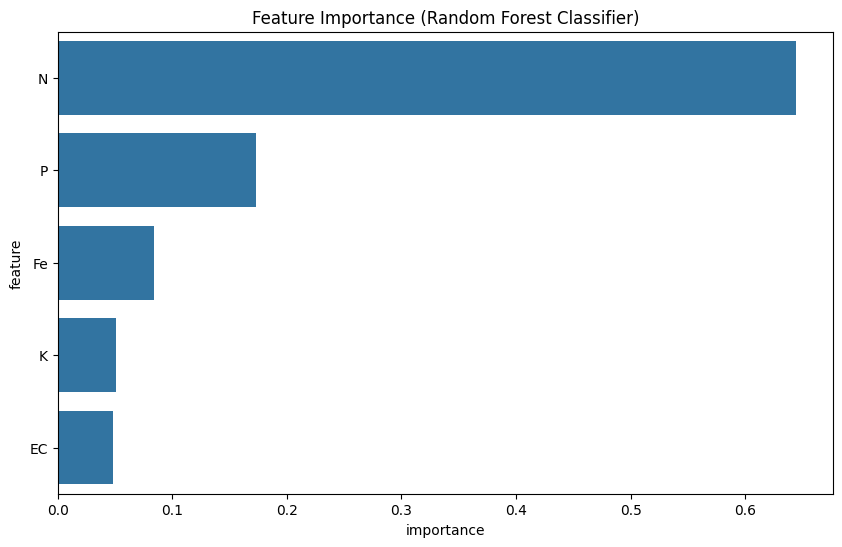

In [5]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_clf = rf_classifier.predict(X_test)

# Print classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_clf))

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest Classifier)')
plt.show()

## Random Forest Regressor

Now, let's implement a Random Forest Regressor to predict continuous values for soil fertility.

Mean Squared Error: 0.1044
R2 Score: 0.7024


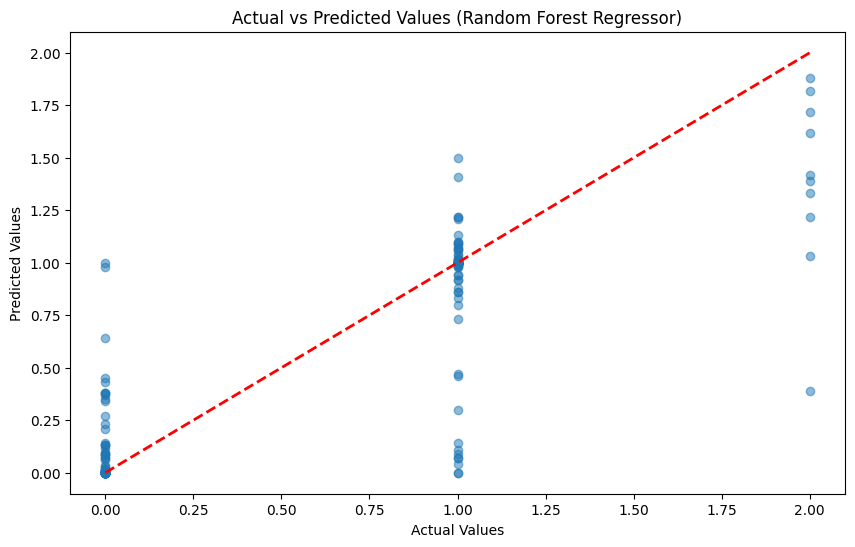

In [6]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred_reg = rf_regressor.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest Regressor)')
plt.show()

## Save Models

Let's save both models for later use in the application layer.

In [7]:
# Save the models
joblib.dump(rf_classifier, '../Models/soil_fertility_classifier.joblib')
joblib.dump(rf_regressor, '../Models/soil_fertility_regressor.joblib')

print("Models have been saved successfully!")

Models have been saved successfully!
